In [1]:
# Importing packages
import math
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import nc_time_axis
from dask.diagnostics import ProgressBar
import re
from xmovie import Movie
%matplotlib inline
import imageio
import math
import pandas as pd


#cartopy
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

import matplotlib.pylab as pl

THRESHOLD = 0.235559205


gridpath = ('/projects/SOCCOM/data/ESM4_PPE/archive/Richard.Slater/xanadu_esm4_20190304_mom6_ESM4_v1.0.3_rc1/GRID/ocean.static.nc')
grid = xr.open_dataset(gridpath)

In [6]:
npp_ppp = xr.open_dataset('/home/saumyam/npp_ppp_m.nc')
tos_ppp = xr.open_dataset('/home/saumyam/tos_ppp_m.nc')
sos_ppp = xr.open_dataset('/home/saumyam/sos_ppp_m.nc')
mld_ppp = xr.open_dataset('/home/saumyam/mld_ppp_m.nc')
chlos_ppp = xr.open_dataset('/home/saumyam/chlos_ppp_m.nc')

o2os_ppp = xr.open_dataset('/home/saumyam/o2os_ppp_m.nc')
no3os_ppp = xr.open_dataset('/home/saumyam/no3os_ppp_m.nc')
po4os_ppp = xr.open_dataset('/home/saumyam/po4os_ppp_m.nc')
phos_ppp = xr.open_dataset('/home/saumyam/phos_ppp_m.nc')

phycos_ppp = xr.open_dataset('/home/saumyam/phycos_ppp_m.nc')
zoocos_ppp = xr.open_dataset('/home/saumyam/zoocos_ppp_m.nc')

## Atlantic Ocean

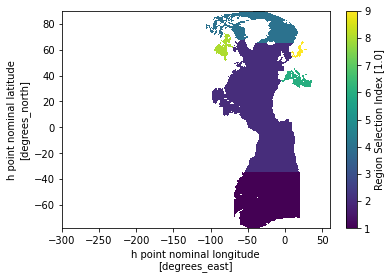

In [7]:
TDF = -68
AFRICA = 20
arctic_atlantic = (grid['geolon']>-110) & (grid['geolon']<AFRICA) & (grid['basin']==4)
atlantic = ((grid['geolon']>TDF) & (grid['basin']==1) & (grid['geolon']<AFRICA)) | (grid['basin']==2) | (arctic_atlantic) | (grid['basin']==8) | (grid['basin']==9) | (grid['basin']==6)
grid['basin'].where(atlantic).plot()

## Pacific Ocean

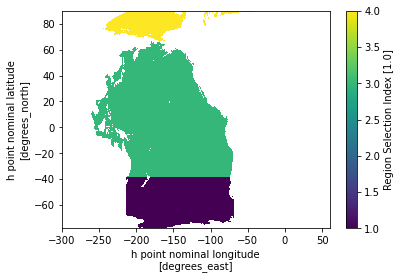

In [8]:
AUS = -180 - (180-(146.55))
s_pac = (grid['geolon']>AUS) & (grid['geolon']<TDF) & (grid['basin']==1) # southern ocean/pacific
a_pac = (grid['geolon']<-110) & (grid['geolon']>-250) & (grid['basin']==4) # arctic ocean/pacific
pacific = s_pac | a_pac | (grid['basin']==3)
grid['basin'].where(pacific).plot()

## Indian Ocean

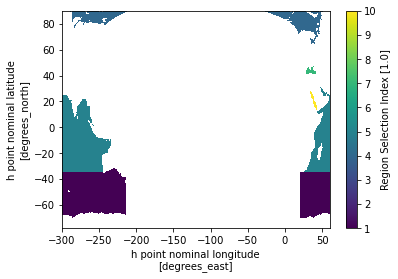

In [9]:
s_ind = ((grid['geolon']<AUS) | (grid['geolon']>AFRICA)) & (grid['basin']==1)
a_ind = ((grid['geolon']<-250) | (grid['geolon']>AFRICA)) & (grid['basin']==4)
indian = s_ind | a_ind | (grid['basin']==5) | (grid['basin']==10) | (grid['basin']==7)
grid['basin'].where(indian).plot()

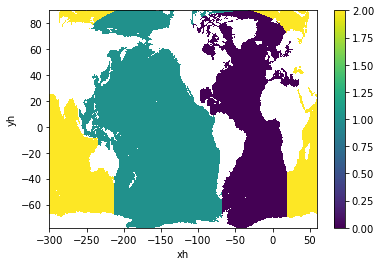

In [11]:
oceans = xr.where(atlantic,grid['basin'],1)
oceans = xr.where(atlantic,0,1)
oceans = xr.where(pacific,1,oceans)
oceans = xr.where(indian,2,oceans)
oceans = oceans.where(grid['basin']!=0) # resetting land to NaN
oceans.plot()

In [10]:
oceans.attrs['flag_values']='0 1 2'
oceans.attrs['flag_meanings']='atlantic_ocean pacific_ocean indian_ocean'


In [12]:
def horizon(driver, driver_ppp):
    smoothed = driver_ppp.rolling(time=12, center=True, min_periods=1).mean()
    smooth_months = xr.where(smoothed<THRESHOLD, smoothed.time,120)
    remask = smooth_months.where(driver_ppp[driver].notnull())
    minimum = remask.min(dim='time',skipna=True)
    return minimum[driver]

In [13]:
def horizon_nosmoothing(driver, driver_ppp):
    smooth_months = xr.where(driver_ppp<THRESHOLD, driver_ppp.time,120)
    remask = smooth_months.where(driver_ppp[driver].notnull())
    minimum = remask.min(dim='time',skipna=True)
    return minimum[driver]

In [14]:
npp_ppp['intpp'].isel(time=2)

<xarray.DataArray 'intpp' (yh: 576, xh: 720)>
[414720 values with dtype=float32]
Coordinates:
  * xh       (xh) float64 -299.8 -299.2 -298.8 -298.2 ... 58.75 59.25 59.75
  * yh       (yh) float64 -77.91 -77.72 -77.54 -77.36 ... 89.47 89.68 89.89
    time     int64 2

In [15]:
def wherenull(driver, driver_ppp):
    null = driver_ppp[driver].isnull() # returns a boolean array
    null_int = xr.where(null, 1, 0)
    null_map = null_int.sum(dim='time')
    null_map = null_map.where(grid['basin']!=0)
    null_map2 = null_map.where(null_map>0)
    return null_map2

/home/saumyam/.conda/envs/saumyac/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/saumyam/.conda/envs/saumyac/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1508: UserWarning: The following kwargs were not used by contour: 'edgecolors'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)


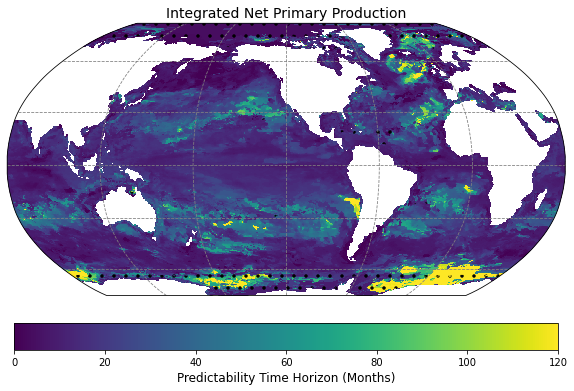

In [93]:
crsP = ccrs.Robinson()
crsT = ccrs.PlateCarree(central_longitude=120)

fig,ax = plt.subplots(figsize=(10,10),subplot_kw={'projection':crsP})
npp_horizon = horizon('intpp',npp_ppp)
null = wherenull('intpp',npp_ppp)
# Specify the longitude and latitude, and the variable that you wish to plot
# Note that here I need to get the latitude and longitude from the grid file
X = grid['geolon']
Y = grid['geolat']
Z = npp_horizon#npp_horizon['intpp'] # .squeeze() gets rid of unnecessary (singular) dimensions

# Create a contour plot of SST
# im = ax.contourf(X,Y,Z,transform=crs)
ax.pcolormesh(X,Y,Z,transform=crsT)
cs = ax.contourf(
    X, Y, null.notnull(),
    transform=crsT,
    colors='none',
    levels=[0.5,1.5],
    edgecolors='white',
    hatches='..',
)

ax.gridlines(color='gray',linestyle='dashed')

ax.set_title('Integrated Net Primary Production',fontsize=14)

# Finally, add a colorbar
cbar = plt.colorbar(im,ax=ax,orientation='horizontal',fraction=0.05,pad=0.05)
cbar.set_label('Predictability Time Horizon (Months)',fontsize=12)
# ax.gridlabels()

/home/saumyam/.conda/envs/saumyac/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


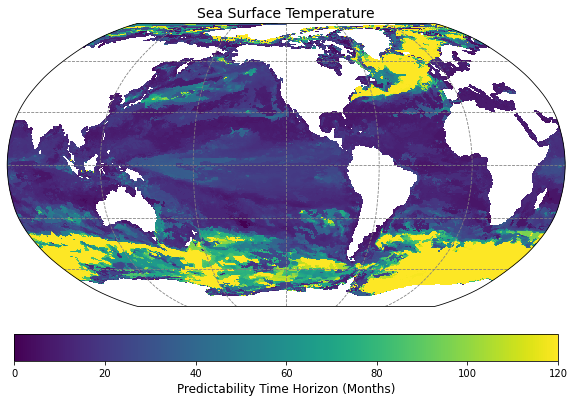

In [88]:
crsP = ccrs.Robinson()
crsT = ccrs.PlateCarree(central_longitude=120)

fig,ax = plt.subplots(figsize=(10,10),subplot_kw={'projection':crsP})
tos_horizon = horizon('tos',tos_ppp)
null = wherenull('tos',tos_ppp)
# Specify the longitude and latitude, and the variable that you wish to plot
# Note that here I need to get the latitude and longitude from the grid file
X = grid['geolon']
Y = grid['geolat']
Z = tos_horizon#npp_horizon['intpp'] # .squeeze() gets rid of unnecessary (singular) dimensions

# Create a contour plot of SST
# im = ax.contourf(X,Y,Z,transform=crs)
im=ax.pcolormesh(X,Y,Z,transform=crsT)
# cs = ax.contourf(
#     X, Y, null.notnull(),
#     transform=crsT,
#     colors='none',
#     levels=[0.5,1.5],
#     edgecolors='white',
#     hatches='..',
# )
ax.gridlines(color='gray',linestyle='dashed')

ax.set_title('Sea Surface Temperature',fontsize=14)

# Finally, add a colorbar
cbar = plt.colorbar(im,ax=ax,orientation='horizontal',fraction=0.05,pad=0.05)
cbar.set_label('Predictability Time Horizon (Months)',fontsize=12)

/home/saumyam/.conda/envs/saumyac/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/saumyam/.conda/envs/saumyac/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1508: UserWarning: The following kwargs were not used by contour: 'edgecolors'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)


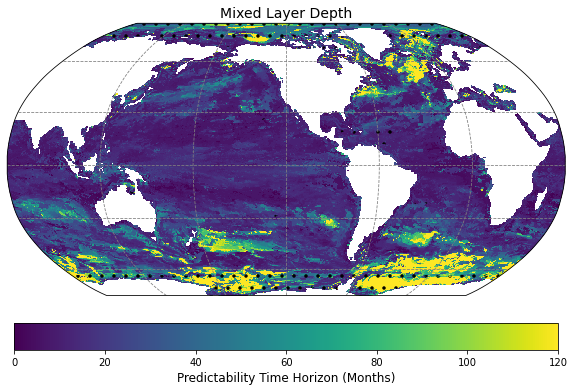

In [92]:
crsP = ccrs.Robinson()
crsT = ccrs.PlateCarree(central_longitude=120)

fig,ax = plt.subplots(figsize=(10,10),subplot_kw={'projection':crsP})
mld_horizon = horizon('MLD_003',mld_ppp)
# Specify the longitude and latitude, and the variable that you wish to plot
# Note that here I need to get the latitude and longitude from the grid file
X = grid['geolon']
Y = grid['geolat']
Z = mld_horizon#npp_horizon['intpp'] # .squeeze() gets rid of unnecessary (singular) dimensions

# Create a contour plot of SST
# im = ax.contourf(X,Y,Z,transform=crs)
im=ax.pcolormesh(X,Y,Z,transform=crsT)
cs = ax.contourf(
    X, Y, null.notnull(),
    transform=crsT,
    colors='none',
    levels=[0.5,1.5],
    edgecolors='white',
    hatches='..',
)
ax.gridlines(color='gray',linestyle='dashed')

ax.set_title('Mixed Layer Depth',fontsize=14)

# Finally, add a colorbar
cbar = plt.colorbar(im,ax=ax,orientation='horizontal',fraction=0.05,pad=0.05)
cbar.set_label('Predictability Time Horizon (Months)',fontsize=12)

/home/saumyam/.conda/envs/saumyac/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/saumyam/.conda/envs/saumyac/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1508: UserWarning: The following kwargs were not used by contour: 'edgecolors'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)


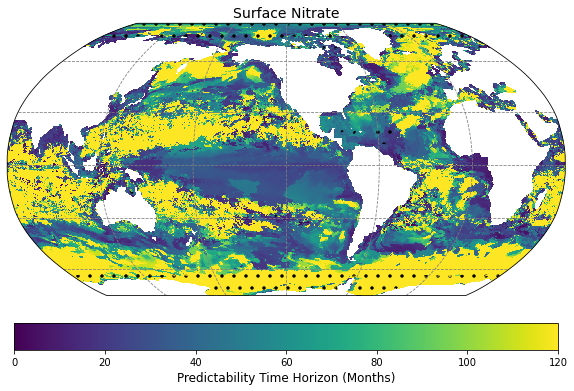

In [106]:
crsP = ccrs.Robinson()
crsT = ccrs.PlateCarree(central_longitude=120)

fig,ax = plt.subplots(figsize=(10,10),subplot_kw={'projection':crsP})
no3os_horizon = horizon('no3os',no3os_ppp)
# Specify the longitude and latitude, and the variable that you wish to plot
# Note that here I need to get the latitude and longitude from the grid file
X = grid['geolon']
Y = grid['geolat']
Z = no3os_horizon#npp_horizon['intpp'] # .squeeze() gets rid of unnecessary (singular) dimensions

# Create a contour plot of SST
# im = ax.contourf(X,Y,Z,transform=crs)
im=ax.pcolormesh(X,Y,Z,transform=crsT)
cs = ax.contourf(
    X, Y, null.notnull(),
    transform=crsT,
    colors='none',
    levels=[0.5,1.5],
    edgecolors='white',
    hatches='..',
)
ax.gridlines(color='gray',linestyle='dashed')

ax.set_title('Surface Nitrate',fontsize=14)

# Finally, add a colorbar
cbar = plt.colorbar(im,ax=ax,orientation='horizontal',fraction=0.05,pad=0.05)
cbar.set_label('Predictability Time Horizon (Months)',fontsize=12)

/home/saumyam/.conda/envs/saumyac/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/saumyam/.conda/envs/saumyac/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1508: UserWarning: The following kwargs were not used by contour: 'edgecolors'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)


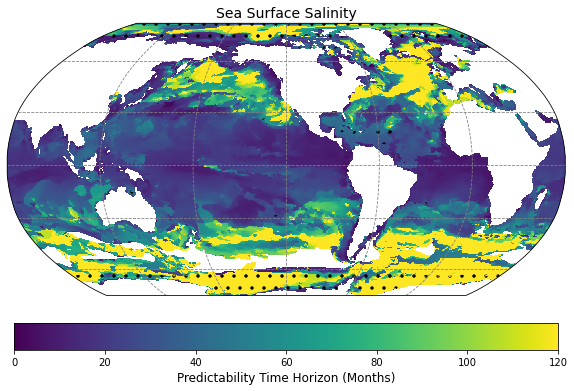

In [94]:
crsP = ccrs.Robinson()
crsT = ccrs.PlateCarree(central_longitude=120)

fig,ax = plt.subplots(figsize=(10,10),subplot_kw={'projection':crsP})
sos_horizon = horizon('sos',sos_ppp)
# Specify the longitude and latitude, and the variable that you wish to plot
# Note that here I need to get the latitude and longitude from the grid file
X = grid['geolon']
Y = grid['geolat']
Z = sos_horizon#npp_horizon['intpp'] # .squeeze() gets rid of unnecessary (singular) dimensions

# Create a contour plot of SST
# im = ax.contourf(X,Y,Z,transform=crs)
im=ax.pcolormesh(X,Y,Z,transform=crsT)
cs = ax.contourf(
    X, Y, null.notnull(),
    transform=crsT,
    colors='none',
    levels=[0.5,1.5],
    edgecolors='white',
    hatches='..',
)
ax.gridlines(color='gray',linestyle='dashed')

ax.set_title('Sea Surface Salinity',fontsize=14)

# Finally, add a colorbar
cbar = plt.colorbar(im,ax=ax,orientation='horizontal',fraction=0.05,pad=0.05)
cbar.set_label('Predictability Time Horizon (Months)',fontsize=12)

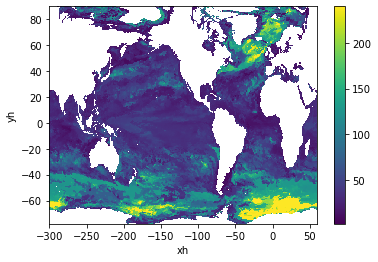

In [90]:
(tos_horizon+npp_horizon).plot()

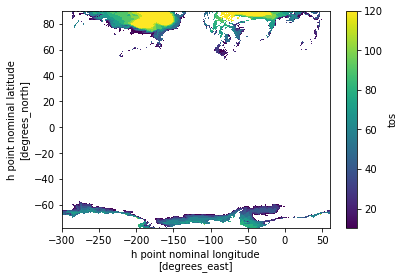

In [18]:
null.plot()

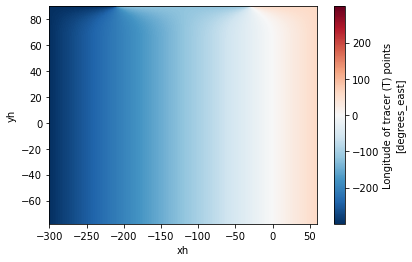

In [19]:
grid['geolon'].plot()

In [20]:
grid['geolat']

<xarray.DataArray 'geolat' (yh: 576, xh: 720)>
array([[-77.907936, -77.907936, -77.907936, ..., -77.907936, -77.907936,
        -77.907936],
       [-77.723816, -77.723816, -77.723816, ..., -77.723816, -77.723816,
        -77.723816],
       [-77.53969 , -77.53969 , -77.53969 , ..., -77.53969 , -77.53969 ,
        -77.53969 ],
       ...,
       [ 64.973076,  65.183586,  65.39247 , ...,  65.39247 ,  65.183586,
         64.973076],
       [ 64.97313 ,  65.18376 ,  65.39275 , ...,  65.39275 ,  65.18376 ,
         64.97313 ],
       [ 64.97316 ,  65.183846,  65.3929  , ...,  65.3929  ,  65.183846,
         64.97316 ]], dtype=float32)
Coordinates:
  * xh       (xh) float64 -299.8 -299.2 -298.8 -298.2 ... 58.75 59.25 59.75
  * yh       (yh) float64 -77.91 -77.72 -77.54 -77.36 ... 89.47 89.68 89.89
Attributes:
    long_name:     Latitude of tracer (T) points
    units:         degrees_north
    cell_methods:  time: point

In [21]:
npp_ppp['intpp'].isel(time=0)

<xarray.DataArray 'intpp' (yh: 576, xh: 720)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * xh       (xh) float64 -299.8 -299.2 -298.8 -298.2 ... 58.75 59.25 59.75
  * yh       (yh) float64 -77.91 -77.72 -77.54 -77.36 ... 89.47 89.68 89.89
    time     int64 0

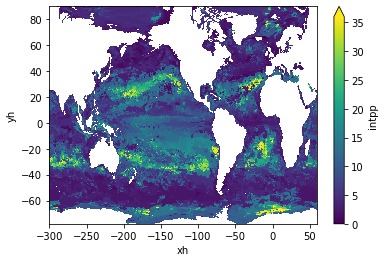

In [96]:
npp_nosmooth = horizon_nosmoothing('intpp',npp_ppp)
npp_nosmooth.plot(vmin=0,vmax=36)

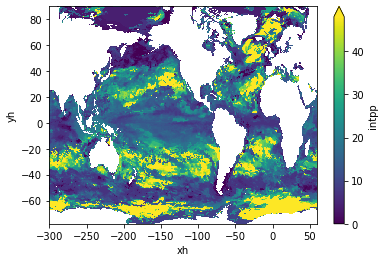

In [23]:
npp_horizon = horizon('intpp',npp_ppp)
npp_horizon.plot(vmin=0,vmax=48)

In [24]:
def horizon_high(driver, driver_ppp):
    smoothed = driver_ppp.rolling(time=12, center=True, min_periods=1).mean()
    smooth_months = xr.where(smoothed<0.5, smoothed.time,120)
    remask = smooth_months.where(driver_ppp[driver].notnull())
    minimum = remask.min(dim='time',skipna=True)
    return minimum[driver]

In [25]:
npp_highly_predictable = horizon_high('intpp',npp_ppp)

Text(0.5, 1.0, 'High Predictability Horizon of NPP')

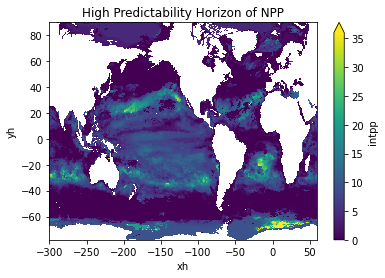

In [154]:
npp_highly_predictable.plot(vmin=0,vmax=36)
plt.title('High Predictability Horizon of NPP')

In [27]:
npp_horizon = horizon('intpp',npp_ppp)

Text(0.5, 1.0, 'Predictability Horizon of NPP')

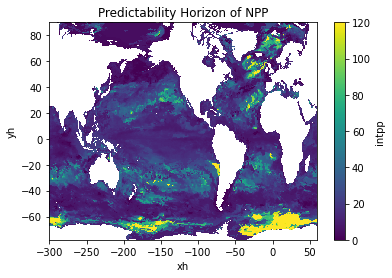

In [155]:
npp_horizon.plot(vmin=0,vmax=120)
plt.title('Predictability Horizon of NPP')

In [28]:
npp_atlantic_mean = npp_horizon.where(oceans==0).weighted(grid['areacello']).mean(['xh'])

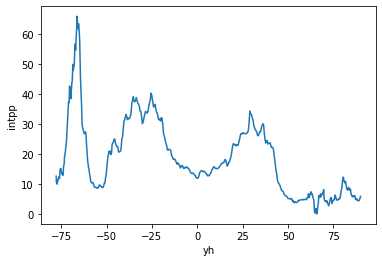

In [29]:
npp_pacific = npp_horizon.where(oceans==1)
npp_pacific_mean = npp_pacific.weighted(grid['areacello']).mean(['xh'])
npp_pacific_mean.plot()

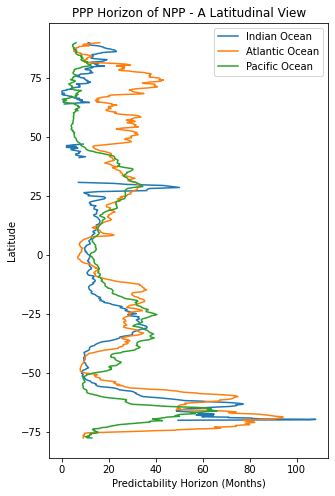

In [126]:
npp_indian = npp_horizon.where(oceans==2)
figure(figsize=(5,8))
npp_indian_mean = npp_indian.weighted(grid['areacello']).mean(['xh'])
npp_indian_mean.plot(label='Indian Ocean',y='yh')
npp_atlantic_mean.plot(label='Atlantic Ocean',y='yh')
npp_pacific_mean.plot(label='Pacific Ocean',y='yh')
plt.ylabel('Latitude')
plt.xlabel('Predictability Horizon (Months)')
plt.title('PPP Horizon of NPP - A Latitudinal View')
plt.legend()

In [31]:
npp = xr.concat([npp_atlantic_mean,npp_pacific_mean,npp_indian_mean],dim='Ocean')
npp.assign_coords({"Ocean": ['Atlantic','Pacific','Indian']})

<xarray.DataArray 'intpp' (Ocean: 3, yh: 576)>
array([[        nan,  9.03448212,  9.06249941, ..., 11.13131184,
        13.47914551, 15.99999885],
       [        nan, 12.69642989, 10.68749861, ...,  5.11816252,
         5.61508195,  5.97456838],
       [        nan,         nan,         nan, ..., 11.15649139,
        11.98719657, 11.14277146]])
Coordinates:
  * yh       (yh) float64 -77.91 -77.72 -77.54 -77.36 ... 89.47 89.68 89.89
  * Ocean    (Ocean) <U8 'Atlantic' 'Pacific' 'Indian'

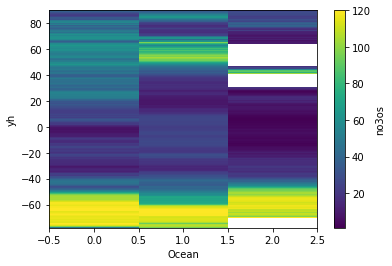

In [33]:
no3os_horizon = horizon('no3os',no3os_ppp)

no3os_atlantic = no3os_horizon.where(oceans==0)
no3os_atlantic_mean = no3os_atlantic.weighted(grid['areacello']).mean(['xh'])

no3os_pacific = no3os_horizon.where(oceans==1)
no3os_pacific_mean = no3os_pacific.weighted(grid['areacello']).mean(['xh'])

no3os_indian = no3os_horizon.where(oceans==2)
no3os_indian_mean = no3os_indian.weighted(grid['areacello']).mean(['xh'])

no3os = xr.concat([no3os_atlantic_mean,no3os_pacific_mean,no3os_indian_mean],dim='Ocean')
no3os.assign_coords({"Ocean": ['Atlantic','Pacific','Indian']})

xr.plot.pcolormesh(no3os,no3os.dims[0],no3os.dims[1])

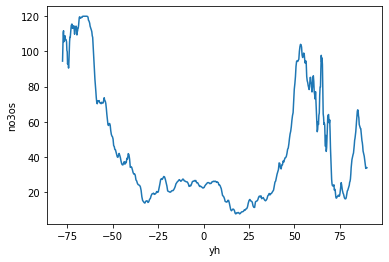

In [34]:
no3os_pacific_mean.plot()

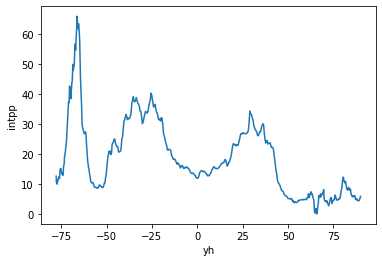

In [35]:
npp_pacific_mean.plot()

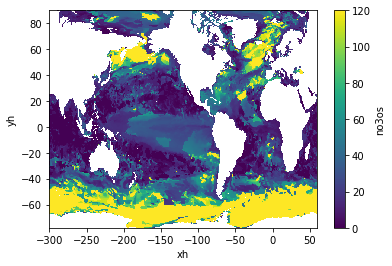

In [36]:
no3os_horizon.plot()

In [37]:
tropics = (grid['geolat']<20) & (grid['geolat']>-20)

npp_tropics = npp_ppp.where(tropics)

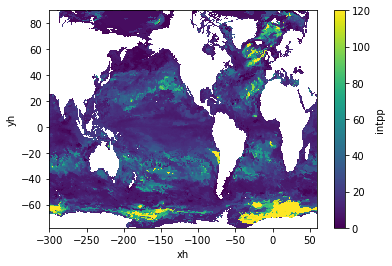

In [38]:
npp_horizon.plot()


In [39]:
npp_tropics_mean = npp_tropics['intpp'].weighted(grid['areacello']).mean(['xh','yh'])

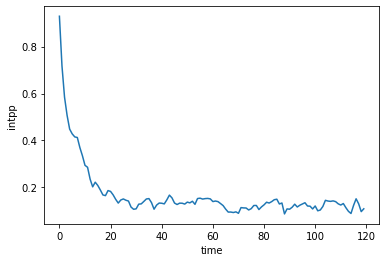

In [40]:
npp_tropics_mean.plot() # predictability of 1 year in the tropics

# Zones

In [41]:
ATL = (grid['basin']==2)
PAC = (grid['basin']==3)
IND = (grid['basin']==5)
SOUTHERN = (grid['basin']==1)

north_subtropic = (grid['geolat'] > 20) & (grid['geolat'] < 45)
north_subpolar = (grid['geolat'] > 45)
equatorial = (grid['geolat'] < 20) & (grid['geolat']>-20)
south_subtropic = (grid['geolat'] < -20)
south_subpolar = (grid['geolat'] > -60)
south_polar = (grid['geolat'] < -60)

# North Subpolar
n_subp_atl = (north_subpolar) & (ATL)
n_subp_pac = (north_subpolar) & (PAC)

# North Subtropics
n_subt_atl = (north_subtropic) & (ATL)
n_subt_pac = (north_subtropic) & (PAC)

# Equatorial
eq_atl = (equatorial) & (ATL)
eq_pac = (equatorial) & (PAC)
eq_ind = (equatorial) & (IND)

# South Subtropics
s_subt_atl = (south_subtropic) & (ATL)
s_subt_pac = (south_subtropic) & (PAC)
s_subt_ind = (south_subtropic) & (IND)

# Southern Ocean - Subpolar
s_subp_atl = (south_subpolar) & (atlantic) & (SOUTHERN)
s_subp_pac = (south_subpolar) & (pacific) & (SOUTHERN)
s_subp_ind = (south_subpolar) & (indian) & (SOUTHERN)

# Southern Ocean - Polar
s_polar_atl = (south_polar) & (atlantic) & (SOUTHERN)
s_polar_pac = (south_polar) & (pacific) & (SOUTHERN)
s_polar_ind = (south_polar) & (indian) & (SOUTHERN)

arctic = grid['basin']==4
# 17 zones, including arctic ocean. Note: sea basins are included in the -1 zone

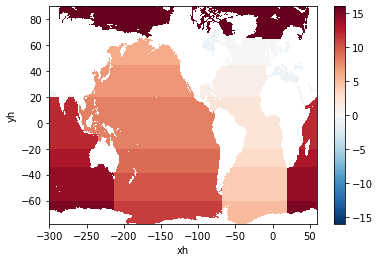

In [42]:
zones = xr.where(n_subp_atl,0,-1)
zones = xr.where(n_subt_atl,1,zones)
zones = xr.where(eq_atl,2,zones)
zones = xr.where(s_subt_atl,3,zones)
zones = xr.where(s_subp_atl,4,zones)
zones = xr.where(s_polar_atl,5,zones)

zones = xr.where(n_subp_pac,6,zones)
zones = xr.where(n_subt_pac,7,zones)
zones = xr.where(eq_pac,8,zones)
zones = xr.where(s_subt_pac,9,zones)
zones = xr.where(s_subp_pac,10,zones)
zones = xr.where(s_polar_pac,11,zones)

zones = xr.where(eq_ind,12,zones)
zones = xr.where(s_subt_ind,13,zones)
zones = xr.where(s_subp_ind,14,zones)
zones = xr.where(s_polar_ind,15,zones)

zones = xr.where(grid['basin']==4,16,zones)

zones = zones.where(grid['basin']!=0)



zones.plot()

In [43]:
zones

<xarray.DataArray (yh: 576, xh: 720)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * xh       (xh) float64 -299.8 -299.2 -298.8 -298.2 ... 58.75 59.25 59.75
  * yh       (yh) float64 -77.91 -77.72 -77.54 -77.36 ... 89.47 89.68 89.89

In [44]:
zones.to_netcdf('/home/saumyam/zones.nc')

In [45]:
grid['basin']

<xarray.DataArray 'basin' (yh: 576, xh: 720)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)
Coordinates:
  * xh       (xh) float64 -299.8 -299.2 -298.8 -298.2 ... 58.75 59.25 59.75
  * yh       (yh) float64 -77.91 -77.72 -77.54 -77.36 ... 89.47 89.68 89.89
Attributes:
    long_name:      Region Selection Index
    standard_name:  region
    units:          1.0
    interp_method:  none
    flag_values:    0 1 2 3 4 5 6 7 8 9 10
    flag_meanings:  global_land southern_ocean atlantic_ocean pacific_ocean a...

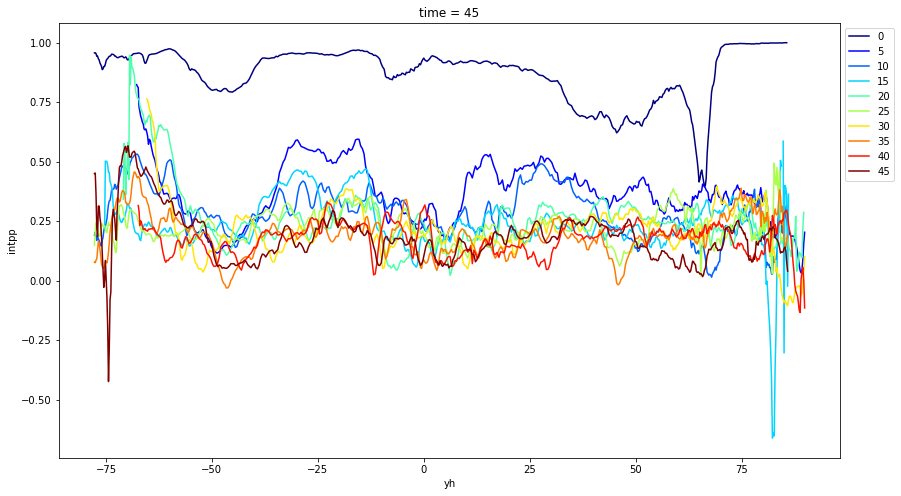

In [46]:
colors = pl.cm.jet(np.linspace(0,1,10))
figure(figsize=(14,8))
c=0
for t in range(0,50,5):
    npp_slice = npp_ppp.isel(time=t)
    time_mean = npp_slice.where(atlantic)['intpp'].weighted(grid['areacello']).mean(['xh'])
    time_mean.plot(label=t,color=colors[c])
    c = c+1
plt.legend(bbox_to_anchor=(1,1))

Text(0.5, 1.0, 'PPP of Integrated NPP at All Latitudes - First 15 Months')

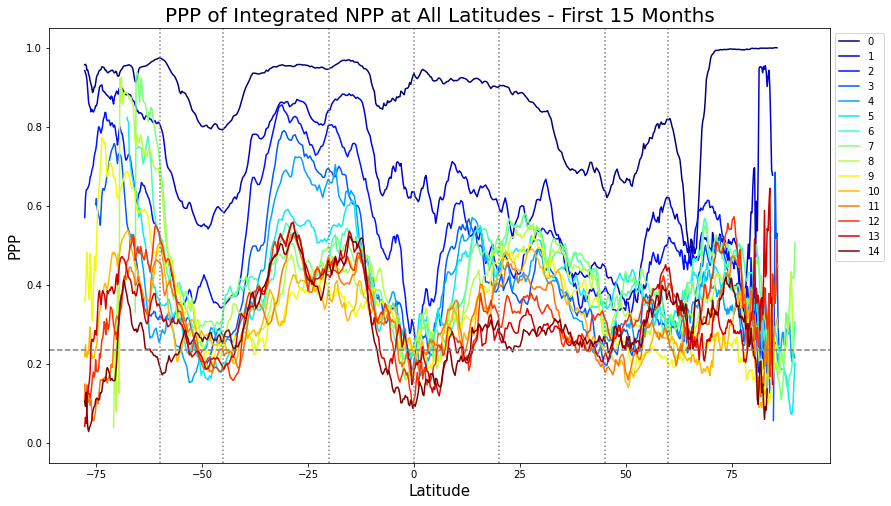

In [152]:
months = 15
colors = pl.cm.jet(np.linspace(0,1,months))
figure(figsize=(14,8))
c=0
for t in range(months):
    npp_slice = npp_ppp.isel(time=t).where(npp_ppp.isel(time=t)>0)
    time_mean = npp_slice.where(atlantic)['intpp'].weighted(grid['areacello']).mean(['xh'])
    time_mean.plot(label=t,color=colors[t])
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel('Latitude',fontsize=15)
plt.axhline(y=0.235, color='grey', linestyle='dashed')
plt.axvline(x=0, color='grey', linestyle='dotted')
plt.axvline(x=-20, color='grey', linestyle='dotted')
plt.axvline(x=20, color='grey', linestyle='dotted')
plt.axvline(x=45, color='grey', linestyle='dotted')
plt.axvline(x=-45, color='grey', linestyle='dotted')
plt.axvline(x=-60, color='grey', linestyle='dotted')
plt.axvline(x=60, color='grey', linestyle='dotted')




plt.ylabel('PPP',fontsize=15)
plt.title('PPP of Integrated NPP at All Latitudes - First 15 Months',fontsize=20)

Text(0, 0.5, 'Latitude')

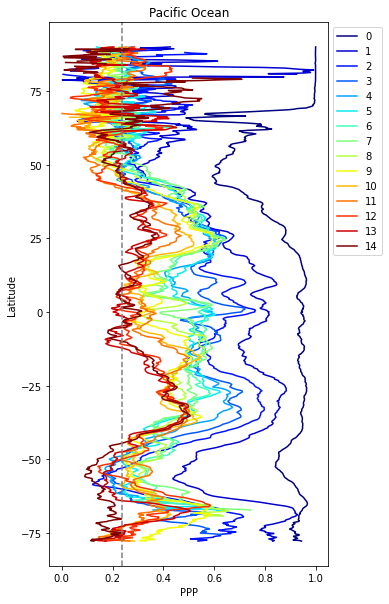

In [135]:
months = 15
colors = pl.cm.jet(np.linspace(0,1,months))
figure(figsize=(5,10))
c=0
for t in range(months):
    npp_slice = npp_ppp.isel(time=t).where(npp_ppp.isel(time=t)>0)
    time_mean = npp_slice.where(pacific)['intpp'].weighted(grid['areacello']).mean(['xh'])
    time_mean.plot(label=t,color=colors[t],y='yh')
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel('PPP')
plt.title('Pacific Ocean')
plt.axvline(x=0.235, color='grey', linestyle='dashed')
plt.ylabel('Latitude')

Text(0, 0.5, 'Latitude')

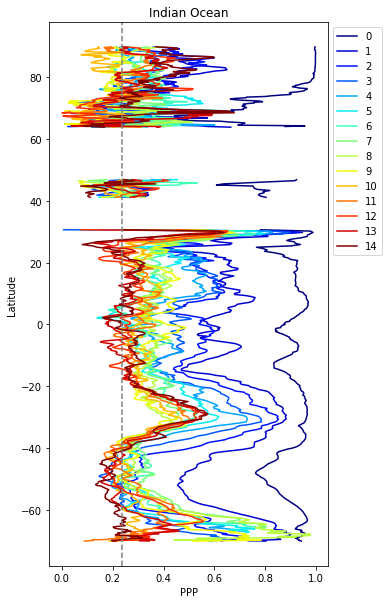

In [136]:
months = 15
colors = pl.cm.jet(np.linspace(0,1,months))
figure(figsize=(5,10))
c=0
for t in range(months):
    npp_slice = npp_ppp.isel(time=t).where(npp_ppp.isel(time=t)>0)
    time_mean = npp_slice.where(indian)['intpp'].weighted(grid['areacello']).mean(['xh'])
    time_mean.plot(label=t,color=colors[t],y='yh')
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel('PPP')
plt.title('Indian Ocean')
plt.axvline(x=0.235, color='grey', linestyle='dashed')
plt.ylabel('Latitude')

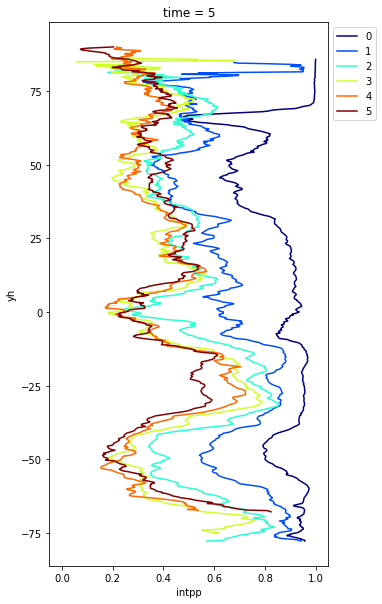

In [48]:
months = 6
colors = pl.cm.jet(np.linspace(0,1,months))
figure(figsize=(5,10))
c=0
for t in range(months):
    npp_slice = npp_ppp.isel(time=t).where(npp_ppp.isel(time=t)>0)
    time_mean = npp_slice.where(atlantic)['intpp'].weighted(grid['areacello']).mean(['xh'])
    time_mean.plot(label=t,color=colors[t],y='yh')
plt.legend(bbox_to_anchor=(1,1))


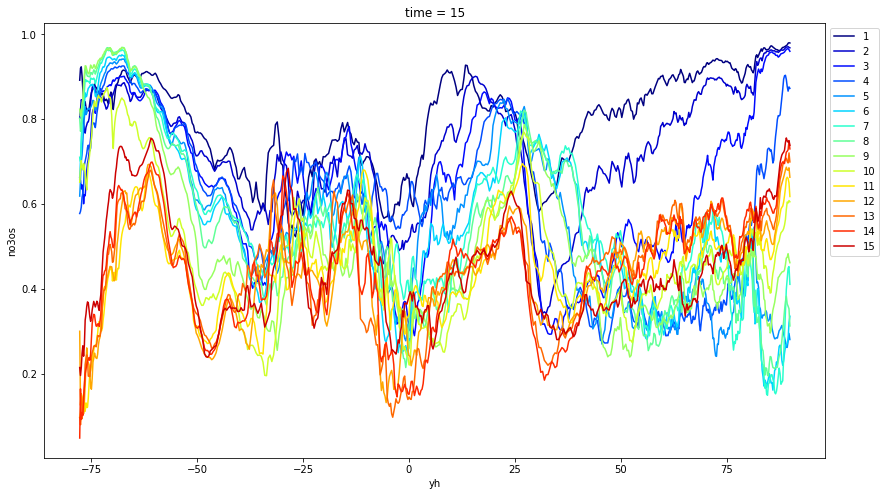

In [49]:
colors = pl.cm.jet(np.linspace(0,1,16))
figure(figsize=(14,8))
c=0
for t in range(1,16):
    no3os_slice = no3os_ppp.isel(time=t).where(no3os_ppp.isel(time=t)>0)
    time_mean = no3os_slice.where(atlantic)['no3os'].weighted(grid['areacello']).mean(['xh'])
    time_mean.plot(label=t,color=colors[c])
    c = c+1
plt.legend(bbox_to_anchor=(1,1))

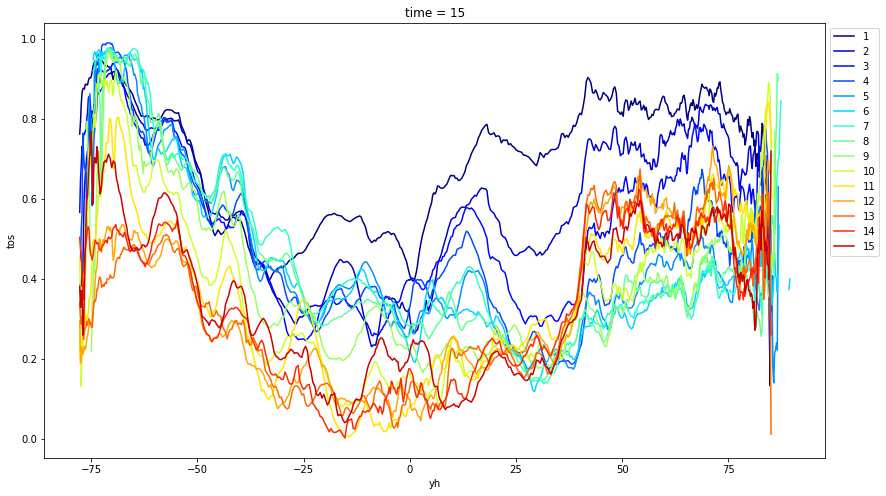

In [50]:
colors = pl.cm.jet(np.linspace(0,1,16))
figure(figsize=(14,8))
c=0
for t in range(1,16):
    tos_slice = tos_ppp.isel(time=t).where(tos_ppp.isel(time=t)>0)
    time_mean = tos_slice.where(atlantic)['tos'].weighted(grid['areacello']).mean(['xh'])
    time_mean.plot(label=t,color=colors[c])
    c = c+1
plt.legend(bbox_to_anchor=(1,1))

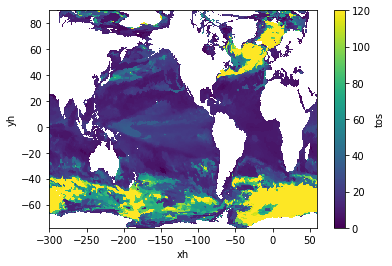

In [51]:
tos_horizon = horizon('tos',tos_ppp)
tos_horizon.plot()

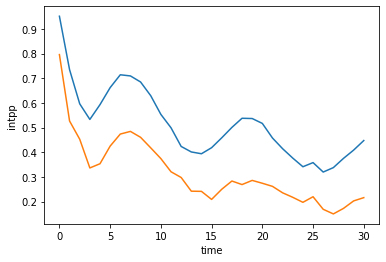

In [52]:
no3os_ppp = no3os_ppp.where(no3os_ppp>0)
no3os_ppp.where(n_subt_atl)['no3os'].weighted(grid['areacello']).mean(['xh','yh']).sel(time=slice(0, 30)).plot()
npp_ppp.where(n_subt_atl)['intpp'].weighted(grid['areacello']).mean(['xh','yh']).sel(time=slice(0, 30)).plot()

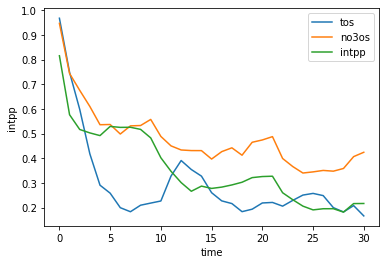

In [53]:
no3os_ppp = no3os_ppp.where(no3os_ppp>0)
tos_ppp = tos_ppp.where(tos_ppp>0)
mld_ppp = mld_ppp.where(mld_ppp>0)
tos_ppp.where(n_subt_pac)['tos'].weighted(grid['areacello']).mean(['xh','yh']).sel(time=slice(0, 30)).plot(label='tos')
no3os_ppp.where(n_subt_pac)['no3os'].weighted(grid['areacello']).mean(['xh','yh']).sel(time=slice(0, 30)).plot(label='no3os')
npp_ppp.where(n_subt_pac)['intpp'].weighted(grid['areacello']).mean(['xh','yh']).sel(time=slice(0, 30)).plot(label='intpp')
plt.legend()

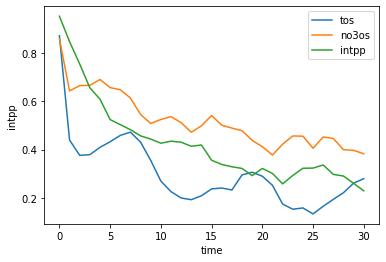

In [54]:
no3os_ppp = no3os_ppp.where(no3os_ppp>0)
tos_ppp = tos_ppp.where(tos_ppp>0)
tos_ppp.where(s_subt_pac)['tos'].weighted(grid['areacello']).mean(['xh','yh']).sel(time=slice(0, 30)).plot(label='tos')
no3os_ppp.where(s_subt_pac)['no3os'].weighted(grid['areacello']).mean(['xh','yh']).sel(time=slice(0, 30)).plot(label='no3os')
npp_ppp.where(s_subt_pac)['intpp'].weighted(grid['areacello']).mean(['xh','yh']).sel(time=slice(0, 30)).plot(label='intpp')
plt.legend()

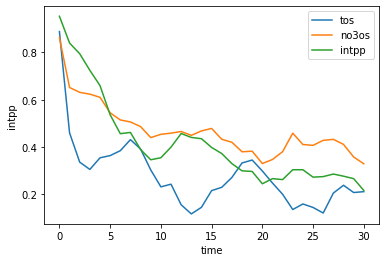

In [55]:
no3os_ppp = no3os_ppp.where(no3os_ppp>0)
tos_ppp = tos_ppp.where(tos_ppp>0)
tos_ppp.where(s_subt_atl)['tos'].weighted(grid['areacello']).mean(['xh','yh']).sel(time=slice(0, 30)).plot(label='tos')
no3os_ppp.where(s_subt_atl)['no3os'].weighted(grid['areacello']).mean(['xh','yh']).sel(time=slice(0, 30)).plot(label='no3os')
npp_ppp.where(s_subt_atl)['intpp'].weighted(grid['areacello']).mean(['xh','yh']).sel(time=slice(0, 30)).plot(label='intpp')
plt.legend()

In [56]:
tos_slice = tos_ppp.where(s_subt_atl)['tos'].weighted(grid['areacello']).mean(['xh','yh']).sel(time=slice(0, 30))
no3os_slice = no3os_ppp.where(s_subt_atl)['no3os'].weighted(grid['areacello']).mean(['xh','yh']).sel(time=slice(0, 30))
npp_slice = npp_ppp.where(s_subt_atl)['intpp'].weighted(grid['areacello']).mean(['xh','yh']).sel(time=slice(0, 30))

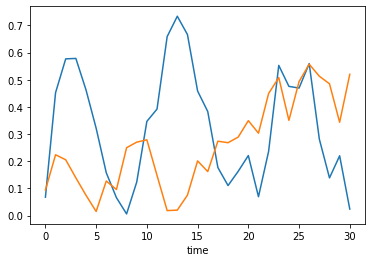

In [57]:
tos_ratio = np.fabs(tos_slice-npp_slice)/npp_slice
no3os_ratio = np.fabs(no3os_slice-npp_slice)/npp_slice
tos_ratio.plot()
no3os_ratio.plot()

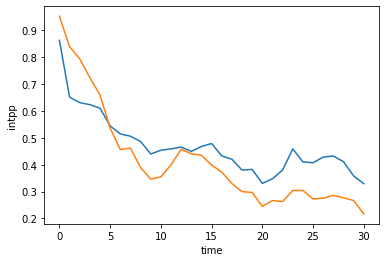

In [58]:
no3os_ppp = no3os_ppp.where(no3os_ppp>0)
no3os_ppp.where(s_subt_atl)['no3os'].weighted(grid['areacello']).mean(['xh','yh']).sel(time=slice(0, 30)).plot()
npp_ppp.where(s_subt_atl)['intpp'].weighted(grid['areacello']).mean(['xh','yh']).sel(time=slice(0, 30)).plot()

In [59]:
mld_ppp = mld_ppp.where(mld_ppp>0)

In [163]:
def ratios(region):
    fig,ax = plt.subplots(1,1,figsize=(8,7))
    months=[*range(0,90,3)]
    ax.set_xticks(months)
   
    tos_slice = tos_ppp.where(region)['tos'].weighted(grid['areacello']).mean(['xh','yh']).sel(time=slice(0, 60))
    no3os_slice = no3os_ppp.where(region)['no3os'].weighted(grid['areacello']).mean(['xh','yh']).sel(time=slice(0, 60))
    npp_slice = npp_ppp.where(region)['intpp'].weighted(grid['areacello']).mean(['xh','yh']).sel(time=slice(0, 60))
    phycos_slice = phycos_ppp.where(region)['phycos'].weighted(grid['areacello']).mean(['xh','yh']).sel(time=slice(0, 60))
    mld_slice = mld_ppp.where(region)['MLD_003'].weighted(grid['areacello']).mean(['xh','yh']).sel(time=slice(0, 60))
    
    tos_slice.plot(label='tos')
    no3os_slice.plot(label='no3os')
    npp_slice.plot(label='intpp')
    #phycos_slice.plot(label='phycos')
    mld_slice.plot(label='MLD')
    plt.axhline(y=0.235, color='grey', linestyle='dashed',label='Predictability Threshold')
    plt.ylabel('PPP')
    plt.xlabel('Lead Time (months)')
    plt.legend()
    plt.show()
    
    tos_ratio = np.fabs(tos_slice-npp_slice)/npp_slice
    no3os_ratio = np.fabs(no3os_slice-npp_slice)/npp_slice
    mld_ratio = np.fabs(mld_slice-npp_slice)/npp_slice
    tos_ratio.plot(label='tos')
    no3os_ratio.plot(label='no3os')
    mld_ratio.plot(label='mld')
    plt.legend()
    plt.show()


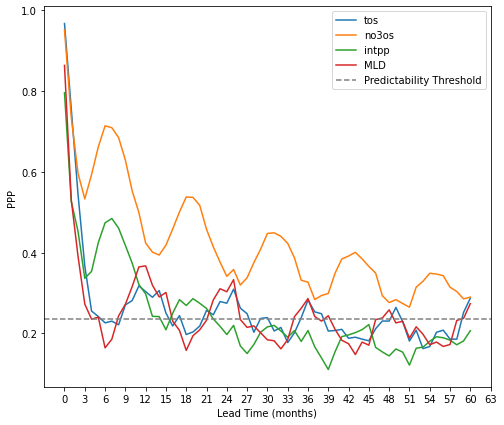

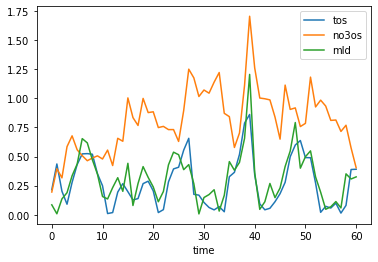

In [164]:
ratios(n_subt_atl)

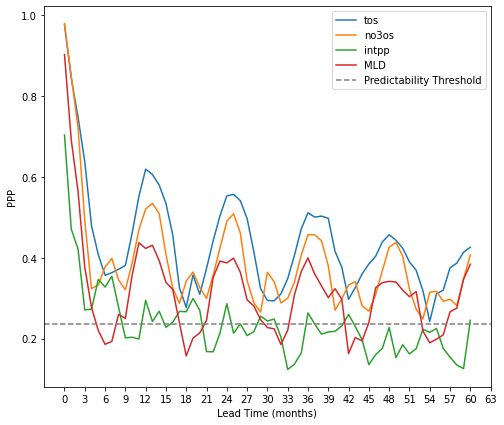

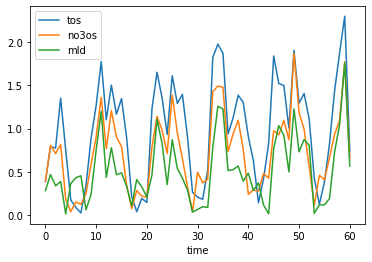

In [165]:
ratios(n_subp_atl)

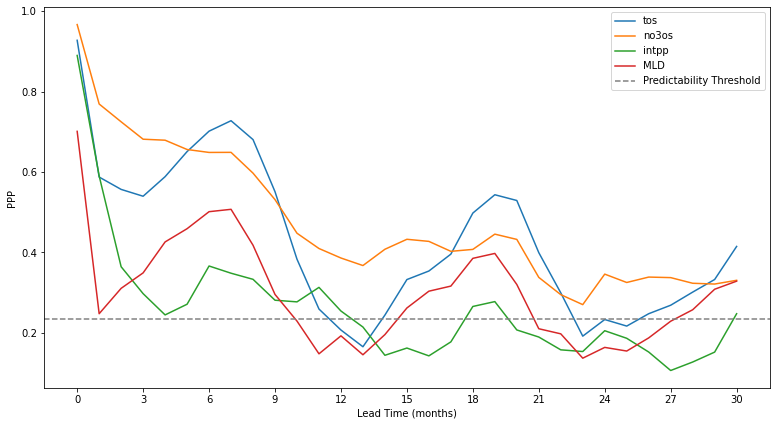

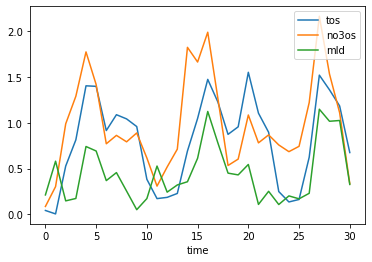

In [116]:
ratios(s_subp_pac)

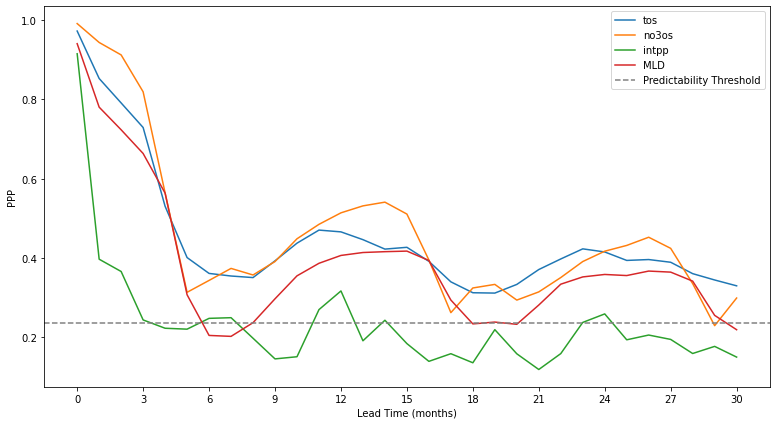

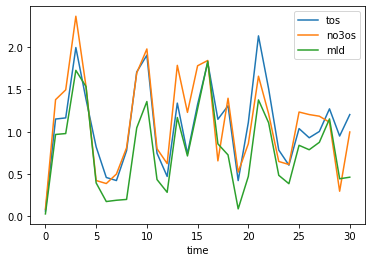

In [117]:
ratios(arctic)

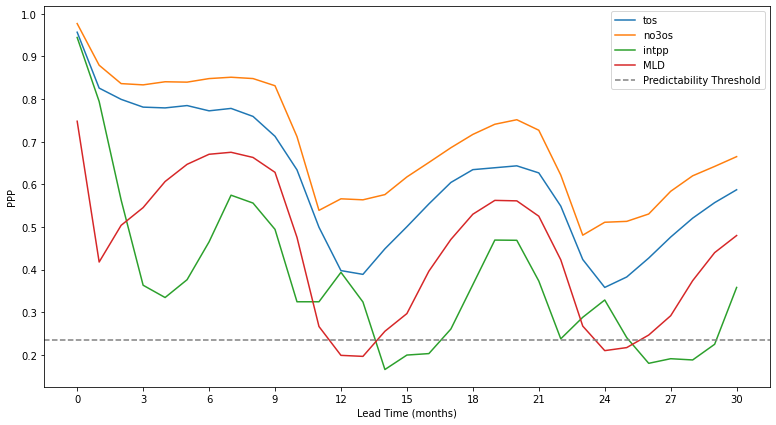

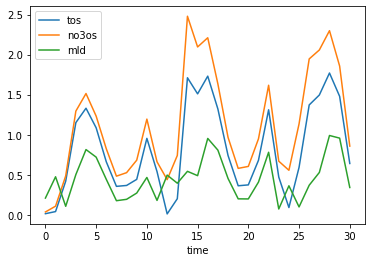

In [118]:
ratios(s_polar_pac|s_polar_atl|s_polar_ind)

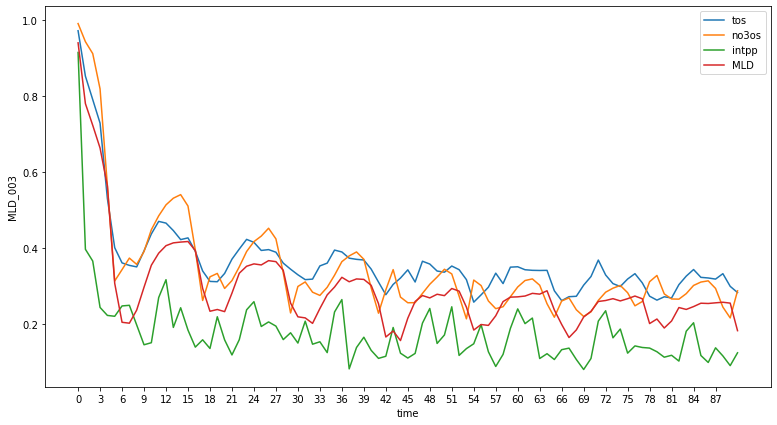

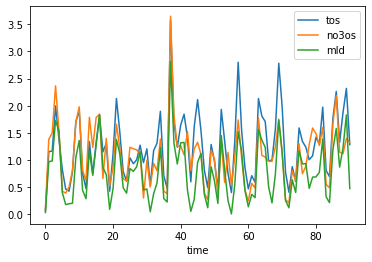

In [74]:
ratios(arctic)

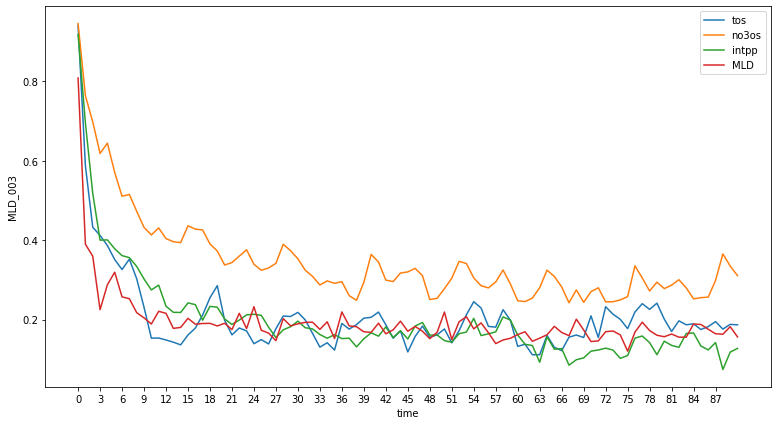

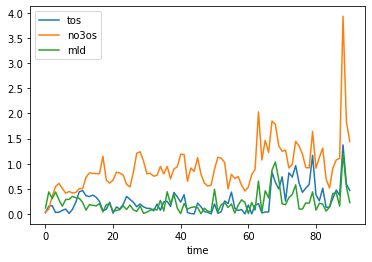

In [66]:
ratios(eq_atl)

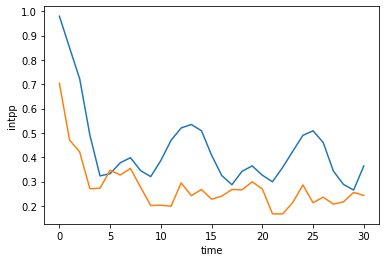

In [67]:
no3os_ppp = no3os_ppp.where(no3os_ppp>0)
no3os_ppp.where(n_subp_atl)['no3os'].weighted(grid['areacello']).mean(['xh','yh']).sel(time=slice(0, 30)).plot()
npp_ppp.where(n_subp_atl)['intpp'].weighted(grid['areacello']).mean(['xh','yh']).sel(time=slice(0, 30)).plot()

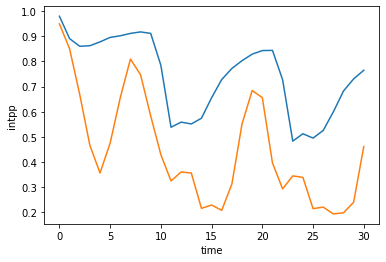

In [68]:
no3os_ppp = no3os_ppp.where(no3os_ppp>0)
no3os_ppp.where(s_polar_atl)['no3os'].weighted(grid['areacello']).mean(['xh','yh']).sel(time=slice(0, 30)).plot()
npp_ppp.where(s_polar_atl)['intpp'].weighted(grid['areacello']).mean(['xh','yh']).sel(time=slice(0, 30)).plot()

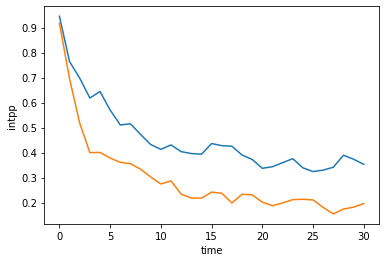

In [69]:
no3os_ppp.where(eq_atl)['no3os'].weighted(grid['areacello']).mean(['xh','yh']).sel(time=slice(0, 30)).plot()
npp_ppp.where(eq_atl)['intpp'].weighted(grid['areacello']).mean(['xh','yh']).sel(time=slice(0, 30)).plot()

In [70]:
zone_labels = ['north_subpolar_atlantic','north_subtropic_atlantic','equatorial_atlantic','south_subtropic_atlantic',
               'south_subpolar_atlantic','south_polar_atlantic','north_subpolar_pacific','north_subtropic_pacific',
               'equatorial_pacific','south_subtropic_pacific','south_subpolar_pacific','south_polar_pacific',
               'equatorial_indian','south_subtropic_indian','south_subpolar_indian','south_polar_indian','arctic']

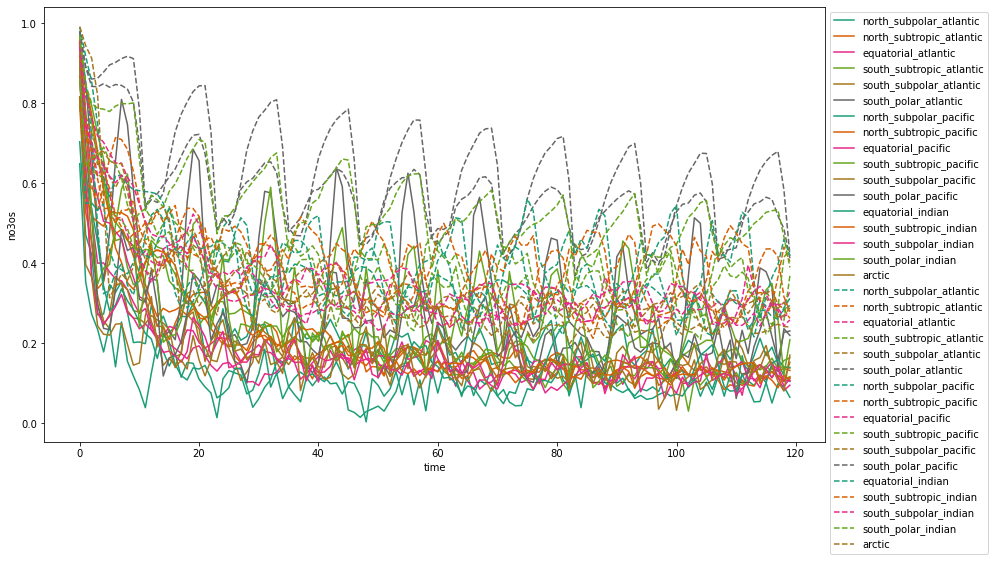

In [71]:
colors = pl.cm.Dark2(np.linspace(0,1,6))
figure(figsize=(14,8))
for zone in range(len(zone_labels)):
    npp_ppp.where(zones==zone)['intpp'].weighted(grid['areacello']).mean(['xh','yh']).plot(label=zone_labels[zone],color=colors[zone%6])
for zone in range(len(zone_labels)):
    no3os_ppp.where(zones==zone)['no3os'].weighted(grid['areacello']).mean(['xh','yh']).plot(label=zone_labels[zone],linestyle='dashed',color=colors[zone%6])

plt.legend(bbox_to_anchor=(1,1))


In [72]:
colors

array([[0.10588235, 0.61960784, 0.46666667, 1.        ],
       [0.85098039, 0.37254902, 0.00784314, 1.        ],
       [0.90588235, 0.16078431, 0.54117647, 1.        ],
       [0.4       , 0.65098039, 0.11764706, 1.        ],
       [0.65098039, 0.4627451 , 0.11372549, 1.        ],
       [0.4       , 0.4       , 0.4       , 1.        ]])